In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pystarboard.data_spacescope as dss
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import numpy.random

import gas_models
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

from sklearn.neighbors import KernelDensity
import pyvinecopulib as pv

In [3]:
# for modeling base-fee to total-gas-usage, we can use more data for training than learning the PSD
# gas usage b/c we want to create a general mapping between basefee and total-gas-usage, regardless
# of message type
training_start_date = date(2021, 12, 1)
training_end_date = date.today()-timedelta(days=3)
df_basefee = gas_models.get_basefee_spacescope(training_start_date, training_end_date)
df_basefee_daily = df_basefee.groupby(df_basefee['hour_date'].dt.date).mean()
gas_train_df = gas_models.get_daily_gasusage_training_data(training_start_date, training_end_date)

In [16]:
train_df = pd.DataFrame()
train_df['daily_base_fee'] = df_basefee_daily['unit_base_fee'].values
train_df['total_gas_used'] = gas_train_df['total_gas_used'].values

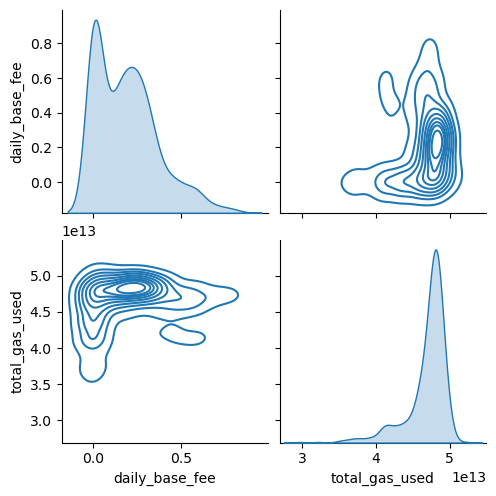

In [17]:
sns.pairplot(train_df, kind='kde')

In [7]:
df_basefee_lily = gas_models.get_message_gas_economy_lily(HEIGHT=3_000_000)
df_basefee_lily=df_basefee_lily.sort_values(by='height')
df_basefee_lily=df_basefee_lily.set_index('height')
firstBlock=df_basefee_lily.index[0]
lastBlock=df_basefee_lily.index[-1]

In [8]:
basefee_totalgas_tsmodel = gas_models.AvgBaseFeeTotalGasUsageARMAModel(df_basefee_lily)
basefee_totalgas_tsmodel.fit()

/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               base_fee   No. Observations:               234357
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -110378.847
Date:                Wed, 27 Sep 2023   AIC                         220763.695
Time:                        09:00:41   BIC                         220794.788
Sample:                             0   HQIC                        220772.784
                             - 234357                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.001    -10.203      0.000      -0.012      -0.008
ar.L1          0.1201      0.002     58.757      0.000       0.116       0.124
sigma2         0.1502      0.001    297.798      0.0

In [9]:
blocks_per_day = 2880*5.0
gstar = 5e9
    
def gt2gtilde(gt_day):
    gt_block = gt_day / blocks_per_day
    gtilde = (gt_block-gstar)/gstar
    return gtilde

In [10]:
# find mapping between gtilde and gas_used from simulation
gtilde_vec = np.linspace(gt2gtilde(5000*1e9), gt2gtilde(60000*1e9), 10)  # could use more data points here, but may not be necessary since things seem to be decently behaved
totalgas_vec = np.zeros_like(gtilde_vec)
for ii, gtilde in enumerate(tqdm(gtilde_vec)):
    gtilde_offset_vec = [gtilde]
    basefee_avg_day, totalgas_day = basefee_totalgas_tsmodel.sample_basefee_avgdaily_totalgas_sumdaily(
        ndays_per_realization=1, 
        nsamps_per_offset=120, 
        gtilde_offset_vec=gtilde_offset_vec,
        same_basefee_within_epoch=True
    )
    totalgas_vec[ii] = np.median(totalgas_day)

# find the gtilde values which get us the gas values we want
inverse_fn = interp1d(totalgas_vec, gtilde_vec)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Median(sum[TotalGas])')

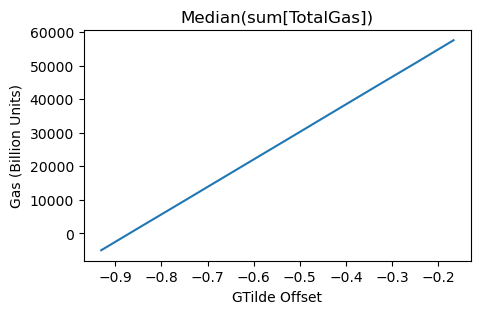

In [11]:
plt.figure(figsize=(5,3))
plt.plot(gtilde_vec, totalgas_vec*1e-9)
plt.xlabel('GTilde Offset')
plt.ylabel('Gas (Billion Units)')
plt.title('Median(sum[TotalGas])')

In [12]:
# sample from ar process w/ an offset to show that the histogram is centered
desired_gt = 50000e9
gtilde_offset_vec = [inverse_fn(desired_gt)]

test_basefee, test_gtilde = basefee_totalgas_tsmodel.sample_basefee(
    ndays_per_realization=1, 
    nsamps_per_offset=120, 
    gtilde_offset_vec=gtilde_offset_vec,
    same_basefee_within_epoch=True
)

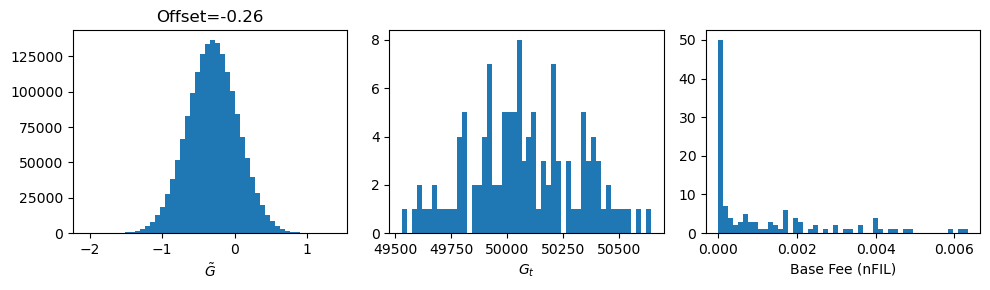

In [13]:
plt.figure(figsize=(10,3))

plt.subplot(131)
plt.hist(test_gtilde, bins=50)
plt.xlabel(r'$\tilde{G}$')
plt.title('Offset=%0.02f' % (inverse_fn(desired_gt), ))

plt.subplot(132)
gt = test_gtilde*gstar + gstar
# aggregate to sum/day
gt_day_sum = gt.reshape(-1,int(blocks_per_day)).T.sum(axis=0)
plt.hist(gt_day_sum*1e-9, bins=50)
plt.xlabel(r'$G_t$')

plt.subplot(133)
basefee_avg_day = test_basefee.reshape(-1,int(blocks_per_day)).T.mean(axis=0)
plt.hist(basefee_avg_day*1e9, bins=50)
plt.xlabel('Base Fee (nFIL)')

plt.tight_layout()

In [14]:
# now, resimulate w/ the correct gtilde vecs
desired_gas_vec = np.linspace(10000, 30000, 25)*1e9
gtilde_offset_vec = np.zeros_like(desired_gas_vec)
for ii, gt in enumerate(desired_gas_vec):
    gtilde_sim = inverse_fn(gt)
    gtilde_offset_vec[ii] = gtilde_sim

# simulate the data for the different total gas usage
basefee_avg_day, totalgas_day = basefee_totalgas_tsmodel.sample_basefee_avgdaily_totalgas_sumdaily(
    ndays_per_realization=1, 
    nsamps_per_offset=len(train_df)//len(gtilde_offset_vec), 
    gtilde_offset_vec=gtilde_offset_vec,
    same_basefee_within_epoch=True
)
# put this into a dataframe
basefee_totalgas_synthetic_df = pd.DataFrame()
basefee_totalgas_synthetic_df['daily_base_fee'] = basefee_avg_day*1e9  # convert to units of nanofil
basefee_totalgas_synthetic_df['total_gas_used'] = totalgas_day

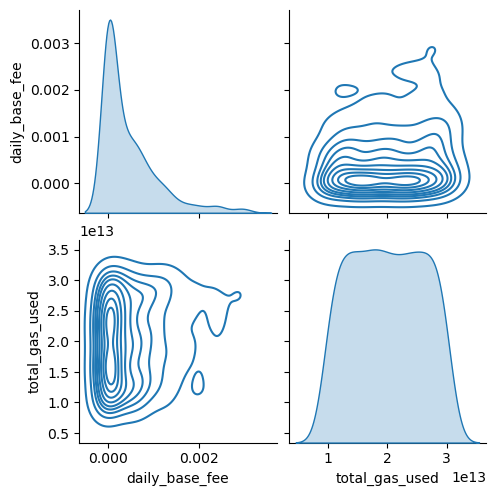

In [15]:
sns.pairplot(basefee_totalgas_synthetic_df, kind='kde')

In [18]:
train_df_full = pd.concat([train_df, basefee_totalgas_synthetic_df], ignore_index=True)

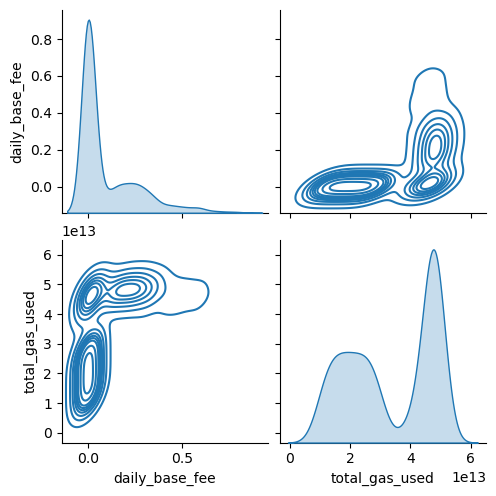

In [19]:
sns.pairplot(train_df_full, kind='kde')